In [27]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
from math import sqrt
from pmdarima.arima import auto_arima
import itertools
import statsmodels.api as sm
from sklearn.metrics import mean_absolute_error,mean_squared_error,mean_absolute_percentage_error

In [2]:
data = pd.read_excel('D:\Mobius Data Analytics\Corrosion Prediction Analysis\Datasets\Dataset for internal CO2 corrosion of oil pipeline.xlsx')

In [3]:
data = data.drop(['Unnamed: 8','Unnamed: 9','Unnamed: 10'],axis=1)

In [4]:
data = data.sample(243,replace=False)

In [5]:
data['Date'] = pd.date_range(start='1/1/2022', periods=len(data), freq='D')

In [6]:
data["month"] = data.Date.dt.month
data["week"] = data.Date.dt.week
data["day"] = data.Date.dt.day
data["day_of_week"] = data.Date.dt.dayofweek
data.head()

,Temperature,Flow velocity,CO2 pressure,Internal pressure,Corrosion Inhibitor efficiency,Shear stress,pH,Corrosion rate,Date,month,week,day,day_of_week
210,50,1.5,2.0,65,40,4,3.9,7.3,2022-01-01,1,52,1,5
179,50,1.2,1.5,70,60,3,3.9,3.9,2022-01-02,1,52,2,6
194,50,1.5,1.0,65,60,4,4.0,3.1,2022-01-03,1,1,3,0
138,40,1.8,1.0,65,40,5,4.0,4.5,2022-01-04,1,1,4,1
169,50,1.2,1.0,70,50,3,4.0,3.7,2022-01-05,1,1,5,2


In [7]:
data.set_index("Date", drop=True, inplace=True)

<AxesSubplot:xlabel='Date'>

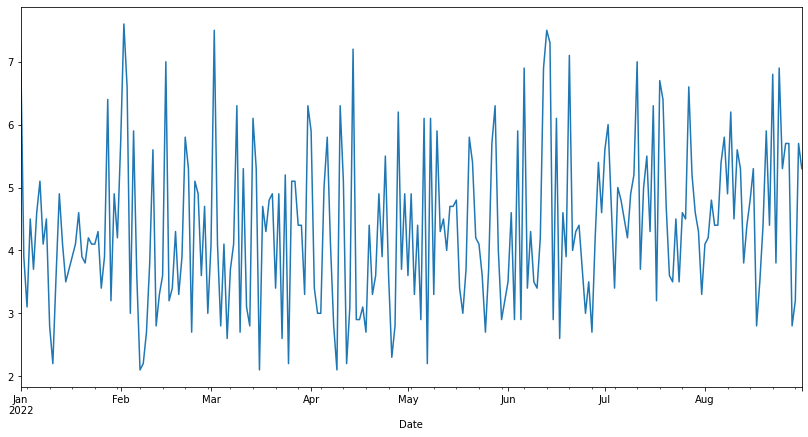

In [8]:
data['Corrosion rate'].plot(figsize=(14, 7))

In [9]:
df_train = data[data.month < 8]
df_valid = data[data.month >= 8]

In [10]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df_train_s = pd.DataFrame(scaler.fit_transform(df_train),columns=df_train.columns)

In [11]:
data.columns

Index(['Temperature', 'Flow velocity', 'CO2 pressure', 'Internal pressure',
       'Corrosion Inhibitor efficiency', 'Shear stress', 'pH',
       'Corrosion rate', 'month', 'week', 'day', 'day_of_week'],
      dtype='object')

In [12]:
exogenous_features = ['Temperature', 'Flow velocity', 'CO2 pressure', 'Internal pressure',
       'Corrosion Inhibitor efficiency', 'Shear stress', 'pH', 'month', 'week', 'day', 'day_of_week']

### ARIMAX with Exogeneous variables

In [13]:
def evalaute(predicitions,actuals):
    errors = abs(predicitions - actuals)
    mape = 100 * np.mean(errors / actuals)
    accuracy = 100 - mape
    rmse = np.sqrt(mean_squared_error(predicitions, actuals))
    mae = mean_absolute_error(predicitions, actuals)
    return accuracy,rmse,mae

In [14]:
arima_model = auto_arima(df_train['Corrosion rate'], trace=True, error_action="ignore", suppress_warnings=True)
arima_model.fit(df_train['Corrosion rate'])

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.42 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=850.815, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=792.416, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.22 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=848.838, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=781.418, Time=0.05 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=760.462, Time=0.07 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=754.835, Time=0.08 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=744.294, Time=0.11 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.55 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.53 sec
 ARIMA(5,1,0)(0,0,0)[0]             : AIC=742.298, Time=0.06 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=752.845, Time=0.05 sec
 ARIMA(5,1,1)(0,0,0)[0]             : AIC=714.059, Time=0.17 sec
 ARIMA(4,1,1)(0,0,0)[0]             : AIC=712.901, Time=0.13 se

ARIMA(order=(3, 1, 1), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [15]:
forecast = arima_model.predict(n_periods=len(df_valid))
df_valid["Forecast_ARIMA"] = forecast

In [16]:
model = auto_arima(df_train['Corrosion rate'], exogenous=df_train[exogenous_features], trace=True, error_action="ignore", suppress_warnings=True)
model.fit(df_train['Corrosion rate'], exogenous=df_train[exogenous_features])

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.45 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=850.815, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=792.416, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.22 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=848.838, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=781.418, Time=0.05 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=760.462, Time=0.07 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=754.835, Time=0.09 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=744.294, Time=0.12 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.49 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.50 sec
 ARIMA(5,1,0)(0,0,0)[0]             : AIC=742.298, Time=0.06 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=752.845, Time=0.04 sec
 ARIMA(5,1,1)(0,0,0)[0]             : AIC=714.059, Time=0.17 sec
 ARIMA(4,1,1)(0,0,0)[0]             : AIC=712.901, Time=0.14 se

ARIMA(order=(3, 1, 1), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [17]:
forecast = model.predict(n_periods=len(df_valid), exogenous=df_valid[exogenous_features])
df_valid["Forecast_ARIMAX"] = forecast

In [18]:
print("RMSE of Auto ARIMAX:", np.sqrt(mean_squared_error(df_valid['Corrosion rate'], df_valid.Forecast_ARIMAX)))
print("nMAE of Auto ARIMAX:", mean_absolute_error(df_valid['Corrosion rate'], df_valid.Forecast_ARIMAX))

RMSE of Auto ARIMAX: 1.0606293744089563
nMAE of Auto ARIMAX: 0.8652849612887865


In [19]:
ARIMAX_Accuracy, ARIMAX_RMSE,ARIMAX_MAE = evalaute(df_valid.Forecast_ARIMAX,df_valid['Corrosion rate'])

In [20]:
ARIMA_Accuracy, ARIMA_RMSE,ARIMA_MAE = evalaute(df_valid.Forecast_ARIMA,df_valid['Corrosion rate'])

#### SARIMAX

### Check Stationarity

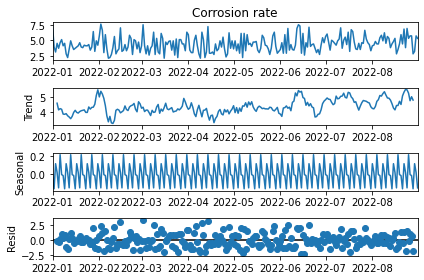

In [21]:
from statsmodels.tsa.seasonal import seasonal_decompose
decompose_data = seasonal_decompose(data['Corrosion rate'], model="additive")
decompose_data.plot();

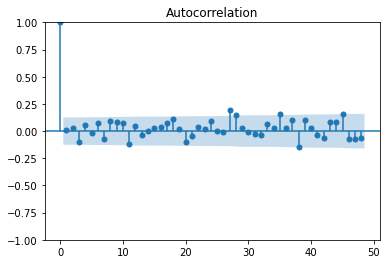

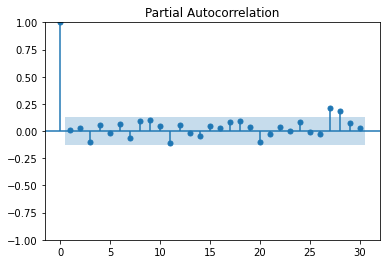

In [22]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(data['Corrosion rate'], lags=48);
plot_pacf(data['Corrosion rate'], lags=30);

In [23]:
critical_pval = 0.05
from statsmodels.tsa.stattools import adfuller
print("Observations of Dickey-fuller test")
dftest = adfuller(data['Corrosion rate'],autolag='AIC')
dfoutput=pd.Series(dftest[0:4],index=['Test Statistic','p-value','#lags used','number of observations used'])
for key,value in dftest[4].items():
    dfoutput['critical value (%s)'%key]= value
print(dfoutput)
print('the series is {}'.format('stationary' if dfoutput[1] < critical_pval else 'not stationary'))

Observations of Dickey-fuller test
Test Statistic                -1.547265e+01
p-value                        2.617663e-28
#lags used                     0.000000e+00
number of observations used    2.420000e+02
critical value (1%)           -3.457664e+00
critical value (5%)           -2.873559e+00
critical value (10%)          -2.573175e+00
dtype: float64
the series is stationary


In [78]:

error = []
for p,d,q in itertools.product(range(3),range(2),range(3)):
    dummy_order=(p,d,q)
    lst = list(dummy_order)
    lst.append(12)                                                          # seasonal frequency
    dummy_seas_order = tuple(lst)
    model=sm.tsa.statespace.SARIMAX(df_train['Corrosion rate'],order=(dummy_order),seasonal_order=(dummy_seas_order),enforce_stationarity=False)   # if exogeneous variable is present as a 3rd column then take exo=df['column_3'] and add exog=exo to the model parameters
    results=model.fit()
    data['Forecast']=results.predict(start=len(df_train),end=len(data)-1,dynamic=True)
    rmse=sqrt(mean_squared_error(data['Forecast'].iloc[len(df_train):len(data)],df_valid['Corrosion rate']))
    error.append([dummy_order,rmse])
error_df = pd.DataFrame(error, columns=['order','rmse']).sort_values(by='rmse')
error_df

,order,rmse
10,"(1, 1, 1)",1.017004
5,"(0, 1, 2)",1.019971
8,"(1, 0, 2)",1.029855
11,"(1, 1, 2)",1.030873
13,"(2, 0, 1)",1.036472
4,"(0, 1, 1)",1.037734
7,"(1, 0, 1)",1.042598
17,"(2, 1, 2)",1.049278
16,"(2, 1, 1)",1.062034
14,"(2, 0, 2)",1.131722


### Without exogenous variables

                                     SARIMAX Results                                      
Dep. Variable:                     Corrosion rate   No. Observations:                  212
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -327.710
Date:                            Wed, 26 Oct 2022   AIC                            665.419
Time:                                    10:53:09   BIC                            681.521
Sample:                                01-01-2022   HQIC                           671.945
                                     - 07-31-2022                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0436      0.074     -0.589      0.556      -0.189       0.102
ma.L1         -0.9831      0.036   

<AxesSubplot:xlabel='Date'>

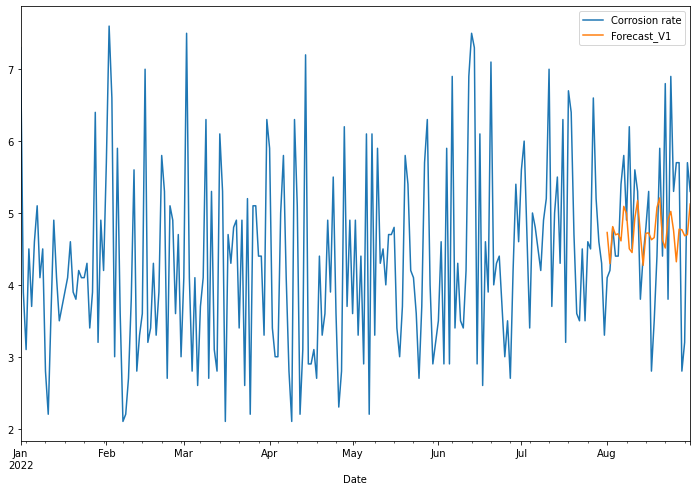

In [29]:
best_order = error_df.iloc[0][0]
blst = list(best_order)
blst.append(12)
best_seasonal_order = tuple(blst)
forcast_model=sm.tsa.statespace.SARIMAX(df_train['Corrosion rate'],order=(best_order),seasonal_order=(best_seasonal_order),enforce_stationarity=False)
forcast_results=forcast_model.fit()
print(forcast_results.summary())
data['Forecast_V1']=forcast_results.predict(start=len(df_train),end=len(data)-1,dynamic=True)
data[['Corrosion rate','Forecast_V1']].plot(figsize=(12,8))

In [38]:
print("RMSE of Auto SARIMA:", np.sqrt(mean_squared_error(data['Corrosion rate'].iloc[212:], data['Forecast_V1'].iloc[212:])))
print("nMAE of Auto SARIMA:", mean_absolute_error(data['Corrosion rate'].iloc[212:], data['Forecast_V1'].iloc[212:]))

RMSE of Auto SARIMA: 1.0170040903391262
nMAE of Auto SARIMA: 0.7901502060482335


In [39]:
SARIMA_Accuracy, SARIMA_RMSE,SARIMA_MAE = evalaute(data['Forecast_V1'].iloc[212:],data['Corrosion rate'].iloc[212:])

### With exogenous variables

In [40]:
data.columns

Index(['Temperature', 'Flow velocity', 'CO2 pressure', 'Internal pressure',
       'Corrosion Inhibitor efficiency', 'Shear stress', 'pH',
       'Corrosion rate', 'month', 'week', 'day', 'day_of_week', 'Forecast',
       'Forecast_V1'],
      dtype='object')

                                     SARIMAX Results                                      
Dep. Variable:                     Corrosion rate   No. Observations:                  212
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                 -47.209
Date:                            Wed, 26 Oct 2022   AIC                            126.419
Time:                                    11:17:45   BIC                            177.945
Sample:                                01-01-2022   HQIC                           147.301
                                     - 07-31-2022                                         
Covariance Type:                              opg                                         
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Temperature                        0.0764      0.003     23.207      0.000

<AxesSubplot:xlabel='Date'>

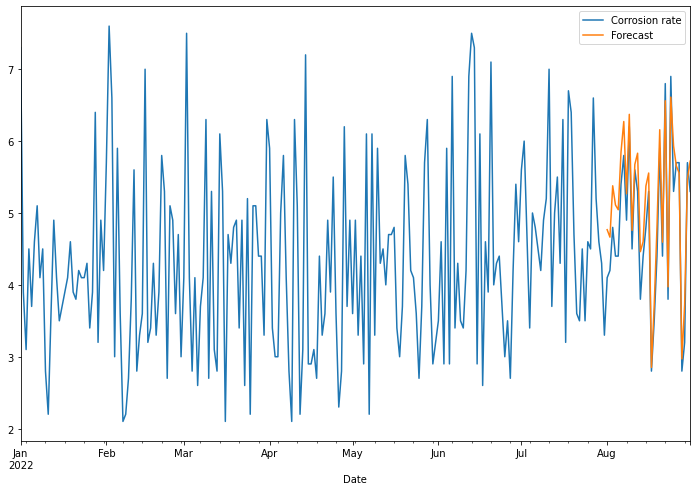

In [81]:
best_order = error_df.iloc[0][0]
blst = list(best_order)
blst.append(12)
best_seasonal_order = tuple(blst)
forcast_model=sm.tsa.statespace.SARIMAX(df_train['Corrosion rate'],order=(best_order),seasonal_order=(best_seasonal_order),enforce_stationarity=False,exog=df_train[exogenous_features])
forcast_results=forcast_model.fit()
print(forcast_results.summary())
data['Forecast']=forcast_results.predict(start=len(df_train),end=len(data)-1,dynamic=True,exog=df_valid[exogenous_features])
data[['Corrosion rate','Forecast']].plot(figsize=(12,8))

In [42]:
print("RMSE of Auto SARIMA:", np.sqrt(mean_squared_error(data['Corrosion rate'].iloc[212:], data['Forecast'].iloc[212:])))
print("nMAE of Auto SARIMA:", mean_absolute_error(data['Corrosion rate'].iloc[212:], data['Forecast'].iloc[212:]))

RMSE of Auto SARIMA: 0.40821508051883393
nMAE of Auto SARIMA: 0.35679255979967645


In [43]:
SARIMAX_Accuracy, SARIMAX_RMSE,SARIMAX_MAE = evalaute(data['Forecast'].iloc[212:],data['Corrosion rate'].iloc[212:])

import pickle
filename = 'SARIMAX_Model_Best.sav'
pickle.dump(forcast_results, open(filename, 'wb'))

file = open("SARIMAX_Model_Best.sav",'rb')
saved_model = pickle.load(file)

In [44]:
data[['Corrosion rate','Forecast']].iloc[212:]

,Corrosion rate,Forecast
Date,,
2022-08-01,4.1,4.767724
2022-08-02,4.2,4.663723
2022-08-03,4.8,5.378396
2022-08-04,4.4,5.111613
2022-08-05,4.4,5.045046
2022-08-06,5.4,5.845813
2022-08-07,5.8,6.272153
2022-08-08,4.9,5.266803
2022-08-09,6.2,6.372278


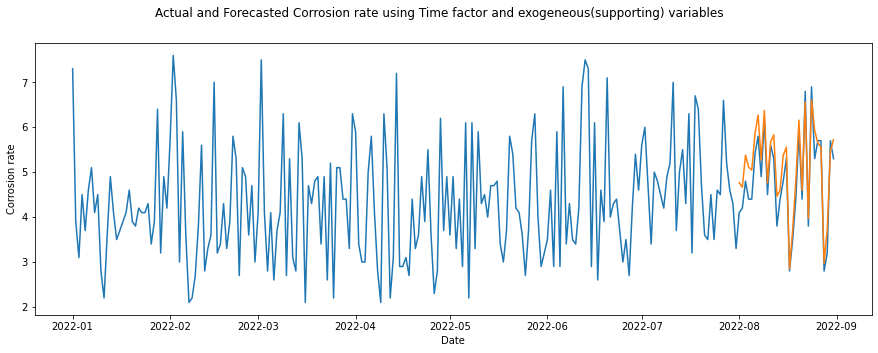

In [45]:
plt.figure(figsize=(15,5))
plt.suptitle("Actual and Forecasted Corrosion rate using Time factor and exogeneous(supporting) variables")
sns.lineplot(data.index,data['Corrosion rate'])
sns.lineplot(data.index,data['Forecast'])
plt.show()

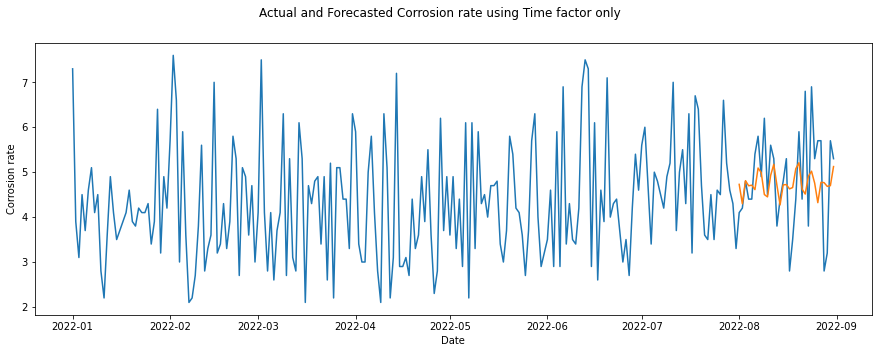

In [46]:
plt.figure(figsize=(15,5))
plt.suptitle("Actual and Forecasted Corrosion rate using Time factor only")
sns.lineplot(data.index,data['Corrosion rate'])
sns.lineplot(data.index,data['Forecast_V1'])
plt.show()

In [47]:
model_evaluation = pd.concat([pd.Series([ARIMAX_Accuracy,ARIMAX_RMSE,ARIMAX_MAE]),
                              pd.Series([SARIMA_Accuracy,SARIMA_RMSE,SARIMA_MAE]),
                              pd.Series([SARIMAX_Accuracy,SARIMAX_RMSE,SARIMAX_MAE])],axis=1)
model_evaluation.rename(columns={0:'ARIMAX(with exog variables)',
                                 1:'SARIMA(without exog varaibles)',2:'SARIMAX (With exog variables)'},inplace=True)
model_evaluation.index = ['Accuracy','RMSE','MAE']
model_evaluation

,ARIMAX(with exog variables),SARIMA(without exog varaibles),SARIMAX (With exog variables)
Accuracy,81.184723,82.217804,92.246065
RMSE,1.060629,1.017004,0.408215
MAE,0.865285,0.790150,0.356793


In [49]:
from pandas.tseries.offsets import DateOffset
future_dates=[data.index[-1]+ DateOffset(days=x)for x in range(0,30)]
future_dates_df=pd.DataFrame(index=future_dates[1:],columns=data.columns)
future_df=pd.concat([data,future_dates_df])

In [61]:
import pickle
file = open("SARIMAX_Model_Best.sav",'rb') 
saved_model = pickle.load(file)

In [62]:
future_df['Forecast'] = saved_model.predict(start = data.shape[0]-1, end = future_df.shape[0]-1, dynamic= True,exog=data[exogenous_features].iloc[:60])  

In [63]:
future_df['Forecast']

2022-01-01         NaN
2022-01-02         NaN
2022-01-03         NaN
2022-01-04         NaN
2022-01-05         NaN
                ...   
2022-09-25    4.987661
2022-09-26    3.407129
2022-09-27    5.021208
2022-09-28    2.722509
2022-09-29    4.235700
Name: Forecast, Length: 272, dtype: float64

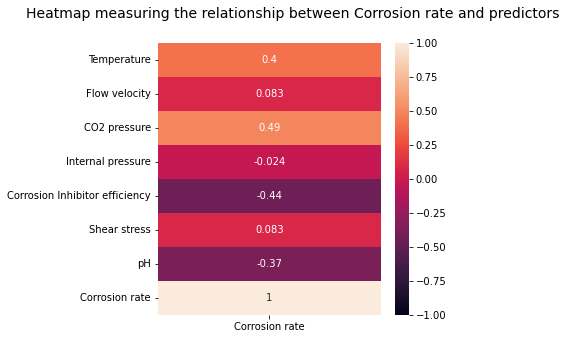

In [65]:
from scipy.stats.stats import kendalltau

plt.figure(figsize = (5,5))
plt.suptitle('Heatmap measuring the relationship between Corrosion rate and predictors\n',
                 horizontalalignment="center",fontstyle = "normal", 
             fontsize = 14, fontfamily = "sans-serif")
sns.heatmap(data.iloc[:,0:8].corr(method='kendall')[['Corrosion rate']],vmin = -1, vmax= 1,annot=True);

In [67]:
saved_model.get_forecast(steps=2,exog=data[exogenous_features].iloc[:2])

In [72]:
saved_model.forecast(steps=10,exog=data[exogenous_features].iloc[-10:])

2022-08-01    6.320197
2022-08-02    3.560890
2022-08-03    6.413390
2022-08-04    5.538310
2022-08-05    5.448055
2022-08-06    5.587283
2022-08-07    2.725827
2022-08-08    3.321889
2022-08-09    5.281872
2022-08-10    5.238805
Freq: D, Name: predicted_mean, dtype: float64

#### Get the model for full data

In [79]:
error = []
for p,d,q in itertools.product(range(3),range(2),range(3)):
    dummy_order=(p,d,q)
    lst = list(dummy_order)
    lst.append(12)                                                          # seasonal frequency
    dummy_seas_order = tuple(lst)
    model=sm.tsa.statespace.SARIMAX(data['Corrosion rate'],order=(dummy_order),seasonal_order=(dummy_seas_order),enforce_stationarity=False,exog=data[exogenous_features])   # if exogeneous variable is present as a 3rd column then take exo=df['column_3'] and add exog=exo to the model parameters
    results=model.fit()
    data['Forecast_full']=results.predict(start=0,end=len(data)-1,dynamic=True)
    rmse=sqrt(mean_squared_error(data['Forecast_full'],data['Corrosion rate']))
    error.append([dummy_order,rmse])
error_df_full = pd.DataFrame(error, columns=['order','rmse']).sort_values(by='rmse')
error_df_full

,order,rmse
6,"(1, 0, 0)",0.255879
1,"(0, 0, 1)",0.255929
7,"(1, 0, 1)",0.255970
0,"(0, 0, 0)",0.256321
14,"(2, 0, 2)",0.258034
13,"(2, 0, 1)",0.258118
8,"(1, 0, 2)",0.258239
12,"(2, 0, 0)",0.258263
2,"(0, 0, 2)",0.258654
4,"(0, 1, 1)",46.393910


                                     SARIMAX Results                                      
Dep. Variable:                     Corrosion rate   No. Observations:                  243
Model:             SARIMAX(1, 0, 0)x(1, 0, 0, 12)   Log Likelihood                 -14.109
Date:                            Wed, 26 Oct 2022   AIC                             56.218
Time:                                    11:17:56   BIC                            104.351
Sample:                                01-01-2022   HQIC                            75.634
                                     - 08-31-2022                                         
Covariance Type:                              opg                                         
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Temperature                        0.0735      0.003     27.526      0.000

<AxesSubplot:xlabel='Date'>

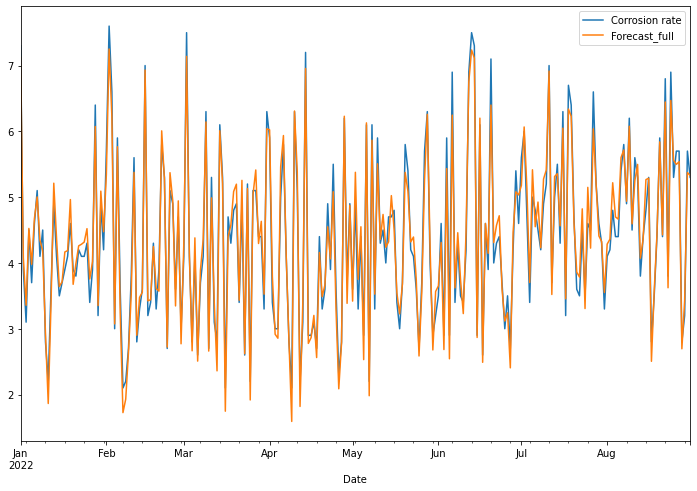

In [82]:
best_order = error_df_full.iloc[0][0]
blst = list(best_order)
blst.append(12)
best_seasonal_order = tuple(blst)
forcast_model_full=sm.tsa.statespace.SARIMAX(data['Corrosion rate'],order=(best_order),seasonal_order=(best_seasonal_order),enforce_stationarity=False,exog=data[exogenous_features])
forcast_results_full=forcast_model_full.fit()
print(forcast_results_full.summary())
data['Forecast_full']=forcast_results_full.predict(start=0,end=len(data)-1,dynamic=True,exog=data[exogenous_features])
data[['Corrosion rate','Forecast_full']].plot(figsize=(12,8))

In [84]:
data['Forecast_full']

Date
2022-01-01    7.123087
2022-01-02    4.078220
2022-01-03    3.357004
2022-01-04    4.524637
2022-01-05    3.979513
                ...   
2022-08-27    5.538738
2022-08-28    2.694906
2022-08-29    3.427792
2022-08-30    5.374390
2022-08-31    5.329645
Name: Forecast_full, Length: 243, dtype: float64

In [86]:
filename = 'SARIMAX_Full_Model_Best.sav' 
pickle.dump(forcast_results_full, open(filename, 'wb'))

In [87]:
file = open("SARIMAX_Full_Model_Best.sav",'rb') 
saved_full_model = pickle.load(file)

In [88]:
steps = 10
saved_full_model.forecast(steps=steps,exog=data[exogenous_features].iloc[-steps:])

2022-09-01    6.449034
2022-09-02    3.621755
2022-09-03    6.480785
2022-09-04    5.567889
2022-09-05    5.512092
2022-09-06    5.530297
2022-09-07    2.701402
2022-09-08    3.432984
2022-09-09    5.377774
2022-09-10    5.322311
Freq: D, Name: predicted_mean, dtype: float64

In [89]:
data

,Temperature,Flow velocity,CO2 pressure,Internal pressure,Corrosion Inhibitor efficiency,Shear stress,pH,Corrosion rate,month,week,day,day_of_week,Forecast,Forecast_V1,Forecast_full
Date,,,,,,,,,,,,,,,
2022-01-01,50,1.5,2.0,65,40,4,3.9,7.3,1,52,1,5,NaN,NaN,7.123087
2022-01-02,50,1.2,1.5,70,60,3,3.9,3.9,1,52,2,6,NaN,NaN,4.078220
2022-01-03,50,1.5,1.0,65,60,4,4.0,3.1,1,1,3,0,NaN,NaN,3.357004
2022-01-04,40,1.8,1.0,65,40,5,4.0,4.5,1,1,4,1,NaN,NaN,4.524637
2022-01-05,50,1.2,1.0,70,50,3,4.0,3.7,1,1,5,2,NaN,NaN,3.979513
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-08-27,40,1.8,2.0,65,50,5,3.9,5.7,8,34,27,5,5.558846,4.774359,5.538738
2022-08-28,30,1.5,1.5,65,60,4,3.9,2.8,8,34,28,6,2.969930,4.766937,2.694906
2022-08-29,50,1.5,1.0,60,60,4,4.0,3.2,8,35,29,0,3.722811,4.683668,3.427792
